Fourth shot at segmenting boat images. Last attempt was somewhat successful, looking at just carefully curated images of clear, large boats in open water, using png masks created directly from the rle file. This time am using carefully curated images where I can see a boat, in any location, along with a representative sample of images that don't contain a boat - open water and coastal. I.e. I've removed images where a boat is claimed but I can't see one, and I'm avoiding the huge number of identical open water no boat images. 970 images total.
Modified get_y_fn to return empty.png if can't find label file - didn't create empty masks for images without boats.
On first attempt was incorrectly looking at old labels, in ocean/train/labels, and so telling network that images with boats didn't have any, so dice stayed around 0.50, couldn't reduce losses any more.
Removed all images as they can't be distributed, as per the Kaggle competition's rules.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import os

In [3]:
imgPath = Path('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2')
lblPath = Path('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/labels')

In [4]:
def get_y_fn(x): 
    base_name, ext = os.path.splitext(x.name)
    mask_name = lblPath/ Path(base_name + ".png")
    if not (os.path.isfile(mask_name)):
        mask_name = lblPath/ Path("empty.png")
    return mask_name

codes = array(['Background', 'Ship'])

In [5]:
fnames = get_image_files(imgPath)
fnames[:3]

[PosixPath('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2/0f3b3c668.jpg'),
 PosixPath('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2/06c880a4c.jpg'),
 PosixPath('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2/109557c2e.jpg')]

In [ ]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
img_f

PosixPath('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2/06c880a4c.jpg')

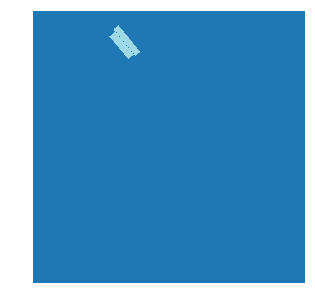

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([768, 768]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
np.unique(mask.data) 

array([0, 1])

In [11]:
bs,size = 3,src_size//3

In [12]:
src = (SegmentationItemList.from_folder(imgPath)
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_func(get_y_fn, classes=codes))

In [13]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [128]:
print("data: ", data)

data:  ImageDataBunch;

Train: LabelList (776 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2;

Valid: LabelList (194 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2;

Test: None


In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

In [25]:
void_code

0

In [15]:
def acc_camvid(input, target):
    # Remove any extraneous extra dimensions in array. I.e. if pass in (1, 3, 1) get (3) back. Trying to get just the image.
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics=acc_camvid, dice
wd=1e-2

In [133]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [134]:
print("learn: ", learn)

learn:  Learner(data=ImageDataBunch;

Train: LabelList (776 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2;

Valid: LabelList (194 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): Batch

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


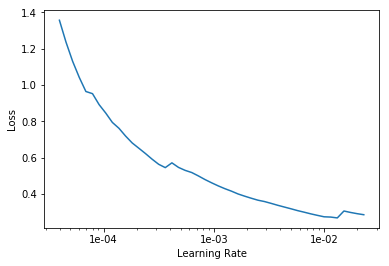

In [135]:
lr_find(learn, start_lr=1e-5, end_lr=10)
learn.recorder.plot()

In [136]:
lr=slice(1e-5, 1e-4)

In [137]:
learn.fit_one_cycle(5, lr, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.042169,0.020051,nan,0.241669,13:43
1,0.015022,0.010767,nan,0.255352,13:43
2,0.011713,0.014907,nan,0.548986,13:43
3,0.008724,0.009547,nan,0.474517,13:41
4,0.007001,0.005510,nan,0.655932,13:39


In [138]:
learn.save('R4-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


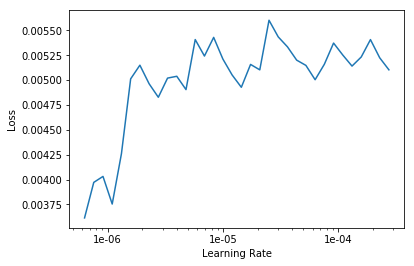

In [139]:
lr_find(learn, start_lr=1e-7, end_lr=10)
learn.recorder.plot()

In [140]:
lr=1e-7
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.004732,0.005359,nan,0.645329,13:38
1,0.006390,0.005401,nan,0.659831,13:39
2,0.008701,0.005439,nan,0.670120,13:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


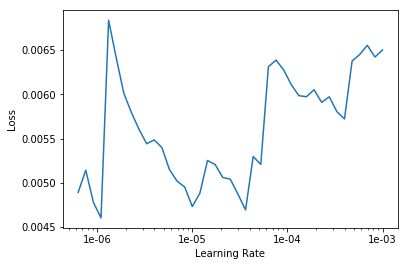

In [141]:
lr_find(learn)
learn.recorder.plot()

In [142]:
lr = 2e-6
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.006423,0.005313,nan,0.664899,13:38
1,0.006086,0.005359,nan,0.678180,13:42
2,0.007338,0.005358,nan,0.674504,13:49


In [143]:
learn.save('R4-stage-2')

In [144]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


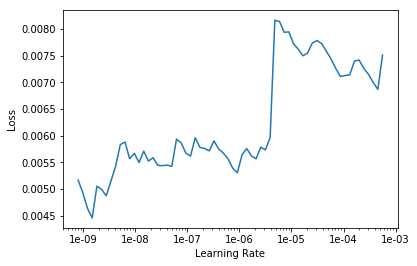

In [145]:
lr_find(learn, start_lr=1e-10, end_lr=1e-1)
learn.recorder.plot()

In [146]:
lrs = slice(8e-10,2e-9)

In [147]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.006849,0.005367,nan,0.674715,14:11
1,0.006288,0.005319,nan,0.674899,14:14
2,0.006522,0.005252,nan,0.673822,14:14
3,0.007462,0.005219,nan,0.675695,14:15
4,0.005405,0.005476,nan,0.664919,14:14


In [148]:
learn.save('R4-stage-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


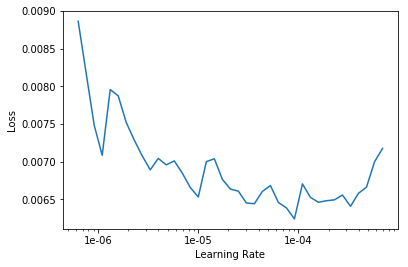

In [149]:
lr_find(learn)
learn.recorder.plot()

In [150]:
lrs = slice(5e-7,1e-6)

In [151]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.005962,0.005343,nan,0.667671,14:12
1,0.006345,0.005210,nan,0.676096,14:14
2,0.005745,0.005333,nan,0.687047,14:14
3,0.006408,0.005097,nan,0.670949,14:15
4,0.006606,0.005162,nan,0.682884,14:14


In [152]:
learn.save('R4-stage-3b');

In [17]:
learn=None
gc.collect()

4443

In [18]:
size = src_size
bs=3

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('R4-stage-3b');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


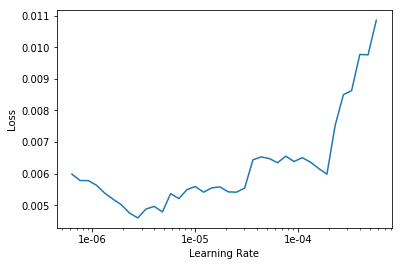

In [157]:
lr_find(learn, start_lr=1e-7, end_lr=10)
learn.recorder.plot()

In [158]:
lr=5e-6

In [159]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.006708,0.005384,nan,0.681536,13:43
1,0.005645,0.005088,nan,0.690677,13:45
2,0.005504,0.004938,nan,0.685242,13:45
3,0.006516,0.004983,nan,0.681845,13:44
4,0.004794,0.004834,nan,0.686134,13:45


In [160]:
learn.save('R4-stage-1-big')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


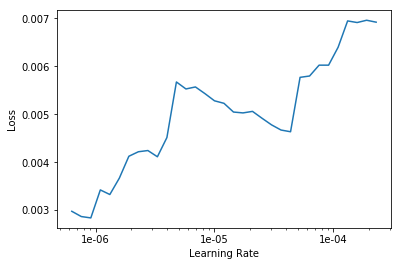

In [161]:
lr_find(learn)
learn.recorder.plot()

In [162]:
lr=3e-5

In [163]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.006485,0.004908,nan,0.683558,13:34
1,0.005653,0.005194,nan,0.683725,13:35


In [164]:
learn.save('R4-stage-1a-big')

In [165]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


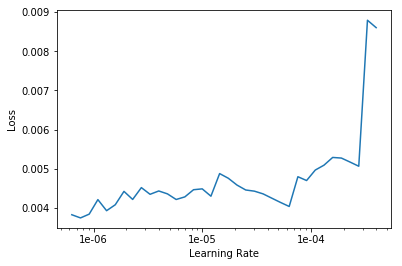

In [166]:
lr_find(learn)
learn.recorder.plot()

In [168]:
lrs = slice(lr/5,2e-5)

In [169]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.005420,0.004818,nan,0.698540,14:09
1,0.007893,0.005100,nan,0.611673,14:11
2,0.004404,0.004948,nan,0.671535,14:11
3,0.004610,0.004734,nan,0.702354,14:18
4,0.005019,0.004485,nan,0.710041,14:20


In [170]:
learn.save('R4-stage-2-big')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


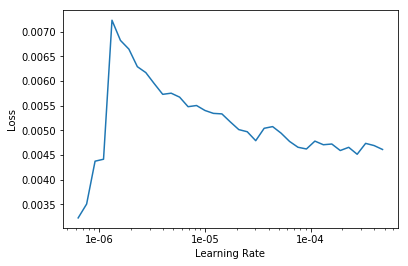

In [171]:
lr_find(learn)
learn.recorder.plot()

In [172]:
lrs = slice(2e-6,6e-6)

In [173]:
learn.fit_one_cycle(2, lrs)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.004427,0.004466,nan,0.702881,14:17
1,0.004782,0.004446,nan,0.721720,14:19


In [174]:
learn.save('R4-stage-2a-big')

In [175]:
learn.fit_one_cycle(2, lrs)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.004668,0.004325,nan,0.737604,14:17
1,0.004071,0.004252,nan,0.721088,14:19


In [176]:
learn.fit_one_cycle(1, lrs)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.004500,0.004309,nan,0.717964,14:19


In [177]:
learn.fit_one_cycle(1, lrs)

epoch,train_loss,valid_loss,acc_camvid,dice,time
0,0.003943,0.004228,nan,0.725932,14:19


In [178]:
learn.save('R4-stage-2b-big')

In [21]:
learn.load('R4-stage-2b-big')

Learner(data=ImageDataBunch;

Train: LabelList (776 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2;

Valid: LabelList (194 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(6

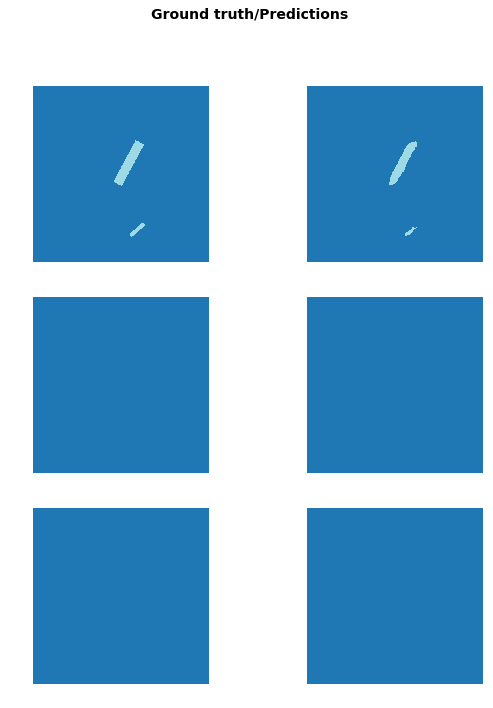

In [22]:
learn.show_results(rows=3, figsize=(9,11), alpha=1)

In [26]:
learn.validate(learn.data.valid_dl)

[0.0042280443, tensor(nan), tensor(0.7259)]

In [ ]:
learn.show_results(ds_type=DatasetType.Valid, alpha=1, rows=4)

In [28]:
img1 = learn.data.valid_ds[4][0]

In [ ]:
img1

In [30]:
pred1=learn.predict(img1)

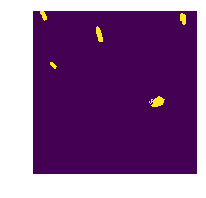

In [31]:
Image(pred1[1]).show()

In [41]:
targ1 = learn.data.valid_ds[4][1]

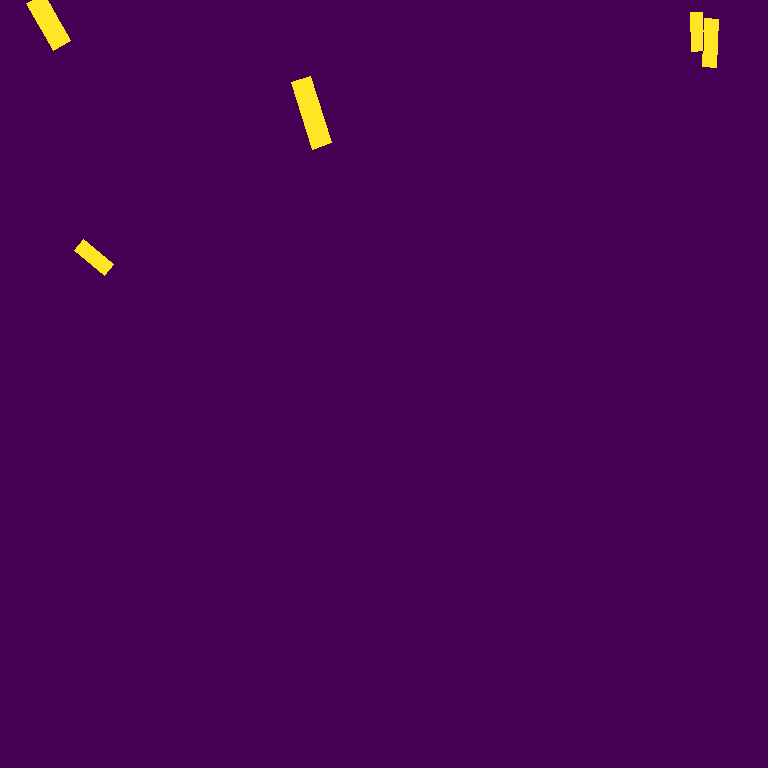

In [42]:
targ1

In [43]:
tvals = targ1.data.flatten()

In [44]:
tvals.sum()

tensor(4371)

In [36]:
learn.data.valid_ds.databunch

<bound method LabelList.databunch of LabelList (194 items)
x: SegmentationItemList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: SegmentationLabelList
ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768),ImageSegment (1, 768, 768)
Path: /home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2>

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [38]:
pred1


(ImageSegment (1, 768, 768), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[9.1210e-01, 9.5106e-01, 9.6634e-01,  ..., 9.9957e-01,
           9.9881e-01, 9.9552e-01],
          [9.4184e-01, 9.7363e-01, 9.7762e-01,  ..., 9.9911e-01,
           9.9888e-01, 9.9795e-01],
          [9.7444e-01, 9.8840e-01, 9.8372e-01,  ..., 9.9936e-01,
           9.9861e-01, 9.9820e-01],
          ...,
          [9.9933e-01, 9.9885e-01, 9.9988e-01,  ..., 9.9996e-01,
           9.9987e-01, 9.9972e-01],
          [9.9793e-01, 9.9553e-01, 9.9949e-01,  ..., 9.9969e-01,
           9.9932e-01, 9.9836e-01],
          [9.9270e-01, 9.9212e-01, 9.9894e-01,  ..., 9.9878e-01,
           9.9685e-01, 9.9118e-01]],
 
         [[8.7899e-02, 4.8943e-02, 3.3658e-02,  ..., 4.2878e-04,
           1.1910e-03, 4.4798e-03],
          [5.8

In [46]:
#learn.data.valid_ds[0]
#learn.data.valid_ds[0][0]
#learn.data.valid_ds[0][1]
learn.data.valid_ds.items[4]

PosixPath('/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2/0f4a0b06c.jpg')

/home/ubuntu/fastai/practical/exercises/lesson1/ocean/train/segphase2/025150f65.jpg
/home/ubuntu/fastai/practical/exercises/lesson1/ocean/labels/empty.png


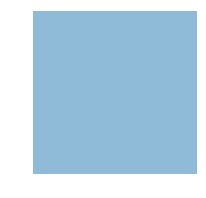

In [47]:
imgFilename = learn.data.valid_ds.items[7]
print(imgFilename)
print(get_y_fn(imgFilename))
mask = open_mask(get_y_fn(imgFilename))
mask.show()

In [ ]:
numEmptyMasks = 0
nrows = 10
tcIndex = 0
numValidCases = len(learn.data.valid_ds.x)
while tcIndex < numValidCases:
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(20,60))
    fig.subplots_adjust(hspace=0.3)
    rowNum = 0
    while rowNum < nrows and tcIndex < numValidCases:
        img = learn.data.valid_ds[tcIndex][0]
        target = learn.data.valid_ds[tcIndex][1]
        pred = learn.predict(img)
    
        # Display images if either target or prediction contain any boat pixels.
        numMaskPixels = target.data.flatten().sum() + pred[1].flatten().sum()
        if numMaskPixels > 0:
            imgFilename = learn.data.valid_ds.items[tcIndex]
            img.show(ax=axs[rowNum][0], title=imgFilename)
            target.show(ax=axs[rowNum][1])
            pred[0].show(ax=axs[rowNum][2])
            rowNum += 1
        else:
            numEmptyMasks += 1
        tcIndex += 1
    plt.show()
print("Empty masks:", numEmptyMasks)

Looks much better! On to full set of data?